In [461]:
import numpy as np
import requests
import pandas as pd
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns
cv = CountVectorizer()
nltk.download("stopwords")
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

stop_words.add('module')
stop_words.add('section')
stop_words.add('learning')
stop_words.add('objective')
stop_words.add('description')
stop_words.add('instructor')
stop_words.add('lp')
stop_words.add('also')
stop_words.add('understanding')
stop_words.add('end')
stop_words.add('youll')
stop_words.add('well')
stop_words.add('including')
stop_words.add('time')
stop_words.add('goal')
stop_words.add('path')
stop_words.add('problem')
stop_words.add('example')
stop_words.add('total')
stop_words.add('go')
stop_words.add('students')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [462]:
url = 'http://localhost:4000/graphql'

# Get all the modules in the DB and convert it to a dataframe

In [463]:
moduleData = requests.post(url, json={'query': '{ module(input:{}){id, name, prefix, hours, objectives, description, keywords} }'}).json()

MODULE_COUNT = len(moduleData.get('data').get('module'))
# CLUSTER_COUNT = np.sqrt(MODULE_COUNT)
CLUSTER_COUNT = 25

In [464]:
moduleDF = pd.DataFrame(moduleData.get('data').get('module'))

moduleDF.head()

,id,name,prefix,hours,objectives,description,keywords
0,644827afc3faa4c9ea96a800,Linear Regression,DS,0.75,"[Linear Regression, Correlation, Regression An...",This module is designed to introduce students ...,[]
1,64496079d5fb014e40d5ea39,Statistical Analysis,DS,1.50,"[Statistical Analysis, Descriptive Statistics,...",This module is designed to teach students the ...,[]
2,644960add5fb014e40d5ea3a,Logarithms,DS,2.00,"[Logarithms, Exponential Functions, Logarithmi...",This module is designed to introduce students ...,[]
3,644960bcd5fb014e40d5ea3b,Arithmetics,DS,0.50,"[Arithmetic, Operations, Addition, Subtraction...",This module is designed to teach students the ...,[]
4,64496111d5fb014e40d5ea3c,Euclidean distance,DS,2.25,"[Euclidean Distance, Distance Formula, Pythago...","In this module, we'll be learning about the Eu...",[]


In [465]:
moduleDF[moduleDF['description'] == '']

,id,name,prefix,hours,objectives,description,keywords
7,646270b939769687f2a6d858,Linear Programming – Modeling Example,LP-ME,0.300000,"[Linear, Programming, Modelling, Linear Progra...",,[]
8,646273ce39769687f2a6d860,Transportation Example,TP,0.700000,"[Transportation, Example, Transportation Examp...",,[]
9,646273e539769687f2a6d861,Transshipment Example,TP,0.730000,"[Transshipment, Example, Transshipment Example...",,[]
10,6462741d39769687f2a6d862,Assignment Problem Example,TP,0.525000,"[Transshipment, Transportation, Shipment, Tran...",,[]
11,6462745c39769687f2a6d863,Shortest Path Example,TP,0.265000,"[Shortest, Path, Example, Shortest Path, Short]",,[]
12,6462747b39769687f2a6d864,Maximal Flow Problem,TP,0.351000,"[Maximal, Flow, Example, Problem]",,[]
13,6462749a39769687f2a6d865,Travelling Salesman Problem,TP,0.750000,"[Travelling, AI, Algorithm, Example, Problem]",,[]
14,646274c539769687f2a6d866,Non-Linear Profit Analysis/Constrained Optimiz...,NFM,0.225000,"[Non-Linear, Optimization, Profit, Analysis, L...",,[]
15,646274e939769687f2a6d867,Facility Location Problem,NFM,0.320000,"[Facility, Location, Problem, Facility Locatio...",,[]
16,6462750d39769687f2a6d868,Mixed Integer Non-Linear Programming,NFM,0.645000,"[Mixed, Integer, Non-Linear, Programming, Line...",,[]


# Merge all the text content into a single column for each module

This is an essential step to be able to perform the text analysis and text vectorization on the data

In [466]:
def scalar_to_str(df):
    lst_o = list(df['objectives'])
    lst_k = list(df['keywords'])

    string_obj_feature = ''
    string_key_feature = ''

    for obj in lst_o:
        string_obj_feature += obj + ' '

    for key in lst_k:
        string_key_feature += key + ' '

    df['objectives'] = string_obj_feature
    df['keywords'] = string_key_feature
    return df

moduleDF = moduleDF.apply(scalar_to_str, axis=1)

In [467]:
moduleDF['feature'] = moduleDF['name'] + ' ' + moduleDF['objectives'] + ' ' + moduleDF['description'] + ' ' + moduleDF['keywords'] + ' ' + moduleDF['prefix']

moduleDF.drop(['name', 'objectives', 'description', 'keywords'], axis=1, inplace=True)

moduleDF.head()

,id,prefix,hours,feature
0,644827afc3faa4c9ea96a800,DS,0.75,Linear Regression Linear Regression Correlatio...
1,64496079d5fb014e40d5ea39,DS,1.50,Statistical Analysis Statistical Analysis Desc...
2,644960add5fb014e40d5ea3a,DS,2.00,Logarithms Logarithms Exponential Functions Lo...
3,644960bcd5fb014e40d5ea3b,DS,0.50,Arithmetics Arithmetic Operations Addition Sub...
4,64496111d5fb014e40d5ea3c,DS,2.25,Euclidean distance Euclidean Distance Distance...


In [468]:
def _text_processing(col: pd.DataFrame()):
    column = col.str.lower()
    column = column.str.replace("[^a-z ]", "")
    word_tokens = column.str.split()
    keys = word_tokens.apply(
        lambda x: [item for item in x if item not in stop_words]
    )
    for i in range(len(keys)):
        keys[i] = " ".join(keys[i])
        column = keys
    return column

In [469]:
moduleDF['cleaned_feature'] = _text_processing(moduleDF['feature'])

/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_10638/2961858478.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  column = column.str.replace("[^a-z ]", "")


In [470]:
moduleDF[moduleDF['cleaned_feature'] == '']

,id,prefix,hours,feature,cleaned_feature


In [471]:
moduleDF.head()

,id,prefix,hours,feature,cleaned_feature
0,644827afc3faa4c9ea96a800,DS,0.75,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...
1,64496079d5fb014e40d5ea39,DS,1.50,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...
2,644960add5fb014e40d5ea3a,DS,2.00,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential functions lo...
3,644960bcd5fb014e40d5ea3b,DS,0.50,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...
4,64496111d5fb014e40d5ea3c,DS,2.25,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...


In [472]:
def get_tokens(text):
    payload = ""

    tokens = word_tokenize(text)

    tokens = [t for t in tokens if not t in stop_words]

    for token in tokens:
        payload += token + ' '

    return payload

In [473]:
moduleDF['tokens'] = moduleDF['cleaned_feature'].apply(lambda x: get_tokens(x))

moduleDF.head()

,id,prefix,hours,feature,cleaned_feature,tokens
0,644827afc3faa4c9ea96a800,DS,0.75,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...,linear regression linear regression correlatio...
1,64496079d5fb014e40d5ea39,DS,1.50,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...,statistical analysis statistical analysis desc...
2,644960add5fb014e40d5ea3a,DS,2.00,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential functions lo...,logarithms logarithms exponential functions lo...
3,644960bcd5fb014e40d5ea3b,DS,0.50,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...,arithmetics arithmetic operations addition sub...
4,64496111d5fb014e40d5ea3c,DS,2.25,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...,euclidean distance euclidean distance distance...


In [474]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(moduleDF['tokens'])

In [475]:
X.toarray()

array([[0.04986707, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06047064, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05564413, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.45992025, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.22655669, ..., 0.        , 0.        ,
        0.        ]])

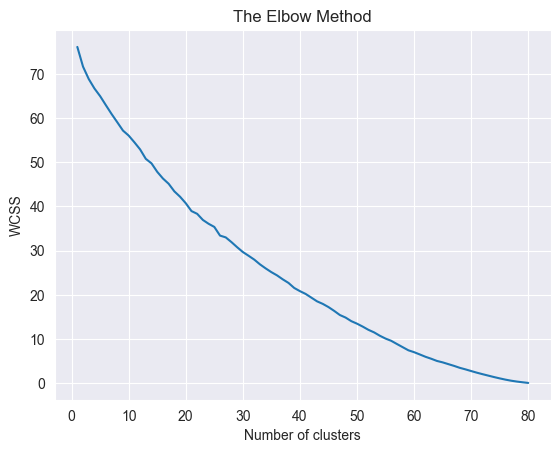

In [476]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, MODULE_COUNT):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',
                random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, MODULE_COUNT), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [477]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=int(CLUSTER_COUNT), random_state=42)

kmeans.fit(X)

clusters = kmeans.labels_

In [478]:
y_pred = kmeans.predict(X)

In [479]:
print(silhouette_score(X, y_pred))

0.1473477777368047


In [480]:
from sklearn.decomposition import PCA

pca = PCA(n_components=int(CLUSTER_COUNT), random_state=42)

reduced_features = pca.fit_transform(X.toarray())

x0 = reduced_features[:, 0]
x1 = reduced_features[:, 1]

In [481]:
moduleDF['cluster'] = clusters
moduleDF['x0'] = x0
moduleDF['x1'] = x1

In [482]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

get_top_keywords(10)


Cluster 0
use,model,new,computer,models,changes,parameters,statistical,analysis,sensitivity

Cluster 1
applications,aoma,ergodic,npd,applying,introduction,lpmc,absorbing,chains,markov

Cluster 2
programming,workload,job,balancing,feasibility,mixedinteger,allocation,binary,integer,variables

Cluster 3
analysis,constrained,equations,np,constraints,nfm,analysisconstrained,optimization,profit,nonlinear

Cluster 4
lpgs,method,variables,decision,feasible,graphical,optimal,constraints,function,solution

Cluster 5
process,queuing,np,arrival,service,waiting,length,lines,queue,rate

Cluster 6
problems,components,modelling,model,lpme,examples,regression,modeling,programming,linear

Cluster 7
directed,shortest,allocation,programmingallocation,dp,gpd,programmingshortest,terms,medical,dynamic

Cluster 8
introduction,problems,irregular,solutions,transshipment,assignment,shipment,tp,transport,transportation

Cluster 9
lpsasa,ai,video,problems,programming,linear,travelling,method,algorithm,simplex

Cl

In [483]:
# cluster_map = {
#     0: 'Introduction to Operations Research Model Formulation and Break-even Analysis',
#     1: 'Linear Programming - Graphical Solution',
#     2: 'Linear Programming Solutions and Sensitivity Analysis',
#     3: 'Linear Programming - Modeling Examples',
#     4: 'Linear Programming - Applications',
#     5: "Integer Programming",
#     6: "Integer Programs - Modeling Examples",
#     7: "Transportation, Transshipment and Assignment Discussion",
#     8: "Network Flow Models",
#     9: "Multi - Criteria Decision Making: Goal Programming",
#     10: "Goal Programming Discussion",
#     11: "Non-Linear Programming",
#     12: 'Non-Linear Programming Discussion',
#     13: 'Applications of Markov Analysis'
# }
#
# moduleDF['cluster'] = moduleDF['cluster'].map(cluster_map)

In [484]:
moduleDF.head(20)

,id,prefix,hours,feature,cleaned_feature,tokens,cluster,x0,x1
0,644827afc3faa4c9ea96a800,DS,0.750,Linear Regression Linear Regression Correlatio...,linear regression linear regression correlatio...,linear regression linear regression correlatio...,6,-0.030043,-0.172622
1,64496079d5fb014e40d5ea39,DS,1.500,Statistical Analysis Statistical Analysis Desc...,statistical analysis statistical analysis desc...,statistical analysis statistical analysis desc...,0,0.042464,-0.222052
2,644960add5fb014e40d5ea3a,DS,2.000,Logarithms Logarithms Exponential Functions Lo...,logarithms logarithms exponential functions lo...,logarithms logarithms exponential functions lo...,21,0.018915,-0.129136
3,644960bcd5fb014e40d5ea3b,DS,0.500,Arithmetics Arithmetic Operations Addition Sub...,arithmetics arithmetic operations addition sub...,arithmetics arithmetic operations addition sub...,21,0.019571,-0.119304
4,64496111d5fb014e40d5ea3c,DS,2.250,Euclidean distance Euclidean Distance Distance...,euclidean distance euclidean distance distance...,euclidean distance euclidean distance distance...,23,0.038400,-0.113372
5,64511f49f9ce74323575fffe,CSLP,0.300,Introduction Linear Programming Modeling Compu...,introduction linear programming modeling compu...,introduction linear programming modeling compu...,0,-0.103483,-0.241533
6,64511f4bf9ce74323575ffff,CSLP,0.300,Computer Solutions for LP Formulations Linear ...,computer solutions formulations linear program...,computer solutions formulations linear program...,9,-0.128056,-0.184367
7,646270b939769687f2a6d858,LP-ME,0.300,Linear Programming – Modeling Example Linear P...,linear programming modeling linear programming...,linear programming modeling linear programming...,6,-0.235172,0.103355
8,646273ce39769687f2a6d860,TP,0.700,Transportation Example Transportation Example ...,transportation transportation transportation i...,transportation transportation transportation i...,8,0.069642,-0.145104
9,646273e539769687f2a6d861,TP,0.730,Transshipment Example Transshipment Example Tr...,transshipment transshipment transshipment intr...,transshipment transshipment transshipment intr...,19,0.050462,-0.047975


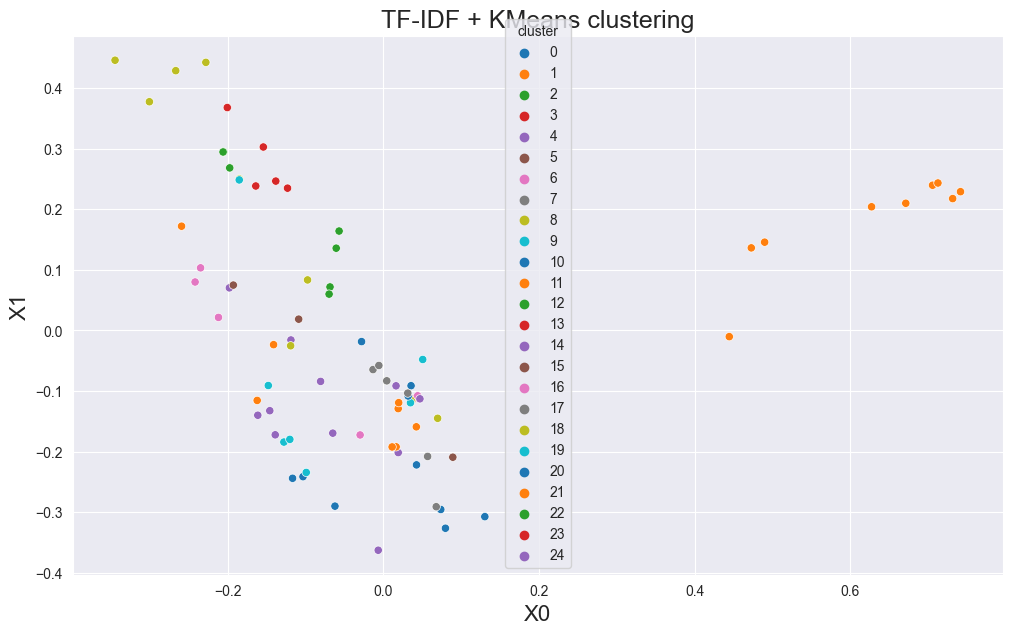

In [485]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=moduleDF, x='x0', y='x1', hue='cluster', palette="tab10")
plt.show()

In [486]:
# sum the number of hours for each cluster
moduleDF.groupby('cluster')['hours'].sum()

cluster
0      4.733289
1     10.812385
2      3.389572
3      2.559414
4      5.639097
5      1.608089
6      3.014354
7      4.901079
8      2.486410
9      6.174270
10     2.275121
11     4.143221
12     1.570203
13     1.665894
14     5.749818
15     2.186363
16     0.265000
17     1.652130
18     7.317483
19     1.444769
20     1.522856
21     4.757577
22     2.518468
23     2.250000
24     0.965819
Name: hours, dtype: float64

<AxesSubplot:title={'center':'ENMA 603 - Total Hours and Module count per Cluster'}, xlabel='Cluster', ylabel='Hours & Count'>

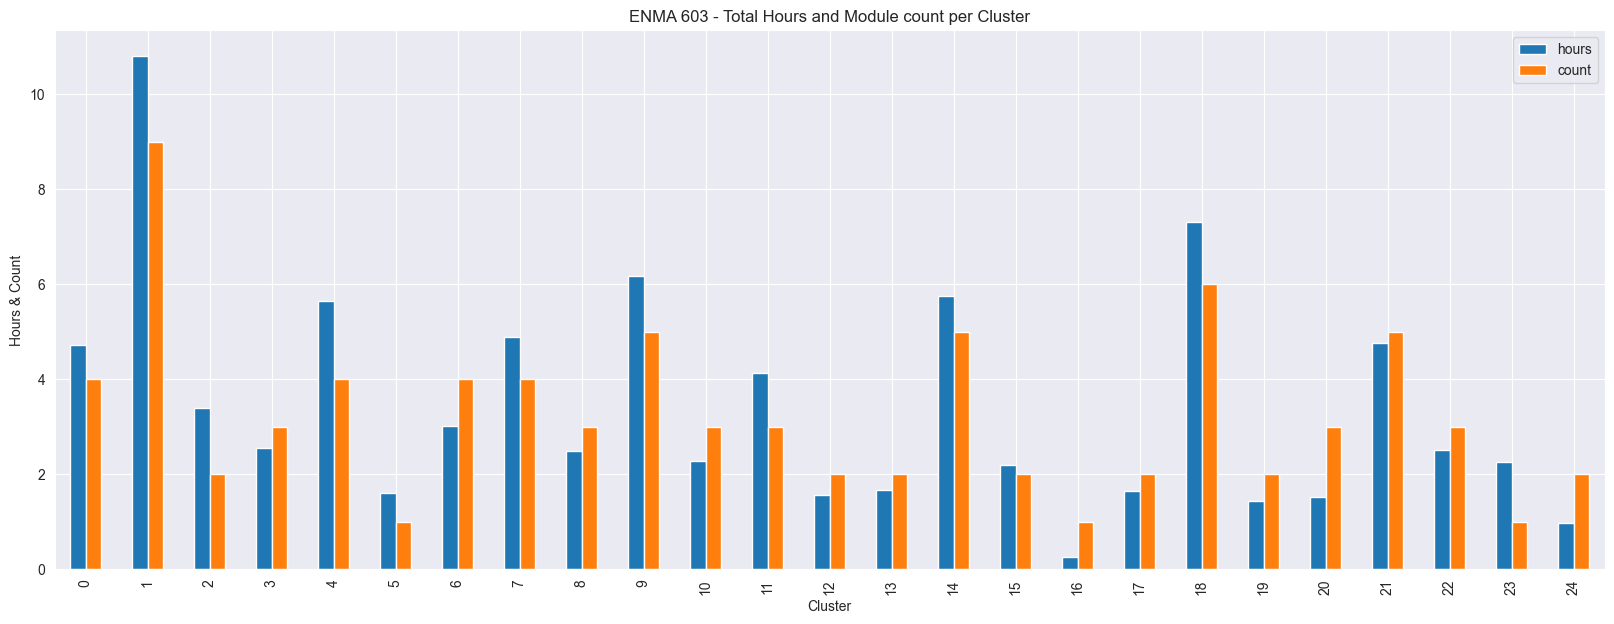

In [487]:
pd.concat(
    [
        moduleDF.groupby('cluster')['hours'].sum().rename('hours'),
        moduleDF.groupby('cluster')['id'].count().rename('count')
    ],
    axis=1
).plot(kind='bar', figsize=(20, 7), title='ENMA 603 - Total Hours and Module count per Cluster', xlabel='Cluster', ylabel='Hours & Count', legend=['Hours', 'Count'])

In [488]:
moduleDF.sort_values(by=['x0', 'x1'], ascending=False)

,id,prefix,hours,feature,cleaned_feature,tokens,cluster,x0,x1
80,646506f78019c4d441f6ec3c,AOMA,1.553647,Applying Markov Chains Markov chains Transi...,applying markov chains markov chains transitio...,applying markov chains markov chains transitio...,1,0.741940,0.229138
26,64627a0e39769687f2a6d872,LP-MC,0.500000,Introduction to Markov Chains Markov Chains In...,introduction markov chains markov chains intro...,introduction markov chains markov chains intro...,1,0.731858,0.217720
28,64627a3b39769687f2a6d874,LP-MC,0.450000,Absorbing Markov Chains Markov Chains Absorbin...,absorbing markov chains markov chains absorbin...,absorbing markov chains markov chains absorbin...,1,0.712918,0.243476
27,64627a2739769687f2a6d873,LP-MC,0.650000,Ergodic Markov Chains Markov Chains Erodic Exa...,ergodic markov chains markov chains erodic lpmc,ergodic markov chains markov chains erodic lpmc,1,0.706007,0.239806
76,646506f68019c4d441f6ec38,NPD,1.957619,Introduction to Markov Chains Markov Chains ...,introduction markov chains markov chains proba...,introduction markov chains markov chains proba...,1,0.671581,0.210027
...,...,...,...,...,...,...,...,...,...
35,646506c28019c4d441f6ec0f,LPGS,0.303309,Linear Programming Graphical Solution This mo...,linear programming graphical solution serves i...,linear programming graphical solution serves i...,6,-0.242227,0.079985
66,646506f48019c4d441f6ec2e,MD MG P,1.034748,Goal Programming Computer Solution Goal prog...,programming computer solution programming opti...,programming computer solution programming opti...,21,-0.259639,0.172138
16,6462750d39769687f2a6d868,NFM,0.645000,Mixed Integer Non-Linear Programming Mixed Int...,mixed integer nonlinear programming mixed inte...,mixed integer nonlinear programming mixed inte...,18,-0.267118,0.428990
50,646506f28019c4d441f6ec1e,IP,1.622044,Integer Programming Optimization Integer ...,integer programming optimization integer binar...,integer programming optimization integer binar...,18,-0.300998,0.377685


array([[<AxesSubplot:title={'center':'hours'}>]], dtype=object)

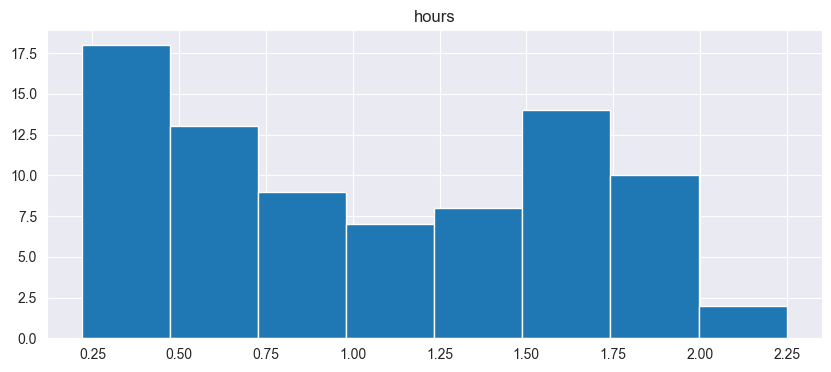

In [489]:
moduleDF.hist(figsize=(10, 4), bins=8, column='hours')